# TODO

- get all player IDs

In [1]:
import pandas as pd

df = pd.read_csv('./statcast-2019-04-10.csv')
df.shape

/Users/dgates/venvs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(620579, 90)

In [2]:
df = df[df.game_year == 2018]
df.shape

(620560, 90)

In [3]:
player_ids = pd.read_excel('/Users/dgates/Downloads/SFBB-Player-ID-Map.xlsx')
player_ids.shape

(2177, 42)

In [4]:
player_ids.head()

,IDPLAYER,PLAYERNAME,BIRTHDATE,FIRSTNAME,LASTNAME,TEAM,LG,POS,IDFANGRAPHS,FANGRAPHSNAME,...,FANDUELID,DRAFTKINGSNAME,OTTONEUID,HQID,RAZZBALLNAME,FANTRAXID,FANTRAXNAME,ROTOWIRENAME,ALLPOS,NFBCLASTFIRST
0,aardsda01,David Aardsma,1981-12-27,David,Aardsma,NaN,NaN,P,1902,David Aardsma,...,NaN,David Aardsma,4362.0,NaN,David Aardsma,NaN,NaN,David Aardsma,P,"Aardsma, David"
1,abadfe01,Fernando Abad,1985-12-17,Fernando,Abad,NaN,NaN,P,4994,Fernando Abad,...,12453.0,Fernando Abad,7372.0,3556.0,Fernando Abad,01viz,"Abad, Fernando",Fernando Abad,P,"Abad, Fernando"
2,abreual01,Albert Abreu,1995-09-26,Albert,Abreu,NYY,AL,P,sa828366,Albert Abreu,...,NaN,NaN,NaN,5762.0,Albert Abreu,NaN,NaN,Albert Abreu,P,"Abreu, Albert"
3,abreubo01,Bobby Abreu,1974-03-11,Bobby,Abreu,NaN,NaN,OF,945,Bobby Abreu,...,NaN,NaN,8984.0,NaN,Bobby Abreu,NaN,NaN,NaN,OF,"Abreu, Bobby"
4,abreujo02,Jose Abreu,1987-01-29,Jose,Abreu,CHW,AL,1B,15676,Jose Abreu,...,49523.0,Jose Abreu,18286.0,4515.0,Jose Abreu,02i2e,"Abreu, Jose","Abreu, Jose",1B,"Abreu, Jose"


In [5]:
player_ids = player_ids[['MLBID', 'MLBNAME', 'TEAM', 'POS']]
batter_ids = player_ids.copy()
batter_ids.columns = [f'batter_{c.lower()}' for c in batter_ids.columns]
pitcher_ids = player_ids.copy()
pitcher_ids.columns = [f'pitcher_{c.lower()}' for c in pitcher_ids.columns]

In [6]:
df = df.merge(batter_ids, left_on='batter', right_on='batter_mlbid', how='left')
df = df.merge(pitcher_ids, left_on='pitcher', right_on='pitcher_mlbid', how='left')
df.shape

(620560, 98)

In [7]:
with pd.option_context('display.max_columns', None):
    display(df.head())

,at_bat_number,away_score,away_team,ax,ay,az,babip_value,balls,bat_score,batter,bb_type,break_angle_deprecated,break_length_deprecated,des,description,effective_speed,error,estimated_ba_using_speedangle,estimated_woba_using_speedangle,events,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,fld_score,game_date,game_pk,game_type,game_year,hc_x,hc_y,hit_distance_sc,hit_location,home_score,home_team,if_fielding_alignment,inning,inning_topbot,iso_value,launch_angle,launch_speed,launch_speed_angle,of_fielding_alignment,on_1b,on_2b,on_3b,outs_when_up,p_throws,pfx_x,pfx_z,pitch_name,pitch_number,pitch_type,pitcher,pitcher.1,plate_x,plate_z,player_name,post_away_score,post_bat_score,post_fld_score,post_home_score,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_dir,spin_rate_deprecated,stand,strikes,sv_id,sz_bot,sz_top,tfs_deprecated,tfs_zulu_deprecated,type,umpire,vx0,vy0,vz0,woba_denom,woba_value,zone,batter_mlbid,batter_mlbname,batter_team,batter_pos,pitcher_mlbid,pitcher_mlbname,pitcher_team,pitcher_pos
0,115.0,7.0,BAL,-10.4412,28.4190,-15.7096,0.0,0.0,3.0,592122.0,NaN,NaN,NaN,Tyler Austin strikes out swinging.,swinging_strike,90.722,NaN,NaN,NaN,strikeout,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,7.0,2018-04-06,529509.0,R,2018.0,NaN,NaN,NaN,2.0,3.0,NYY,Standard,14.0,Bot,0.0,NaN,NaN,NaN,Standard,NaN,NaN,NaN,2.0,R,-0.7285,1.3626,4-Seam Fastball,3.0,FF,542960.0,542960.0,0.4224,3.4716,Brad Brach,7.0,3.0,7.0,3.0,5.839,-2.5964,54.6608,6.1537,91.7,2195.0,NaN,NaN,R,2.0,NaN,1.4472,3.2454,NaN,NaN,S,NaN,9.0707,-133.0662,-3.7404,1.0,0.0,12.0,592122.0,Tyler Austin,MIN,1B,542960.0,Brad Brach,NaN,P
1,115.0,7.0,BAL,-10.1062,29.7698,-9.9198,NaN,0.0,3.0,592122.0,NaN,NaN,NaN,NaN,foul,90.970,NaN,NaN,NaN,NaN,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,7.0,2018-04-06,529509.0,R,2018.0,NaN,NaN,NaN,NaN,3.0,NYY,Standard,14.0,Bot,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,2.0,R,-0.6601,1.7870,4-Seam Fastball,2.0,FF,542960.0,542960.0,0.9707,2.5324,Brad Brach,7.0,3.0,7.0,3.0,5.781,-2.6948,54.7186,6.0787,92.3,2157.0,NaN,NaN,R,1.0,NaN,1.5890,3.4670,NaN,NaN,S,NaN,10.5851,-133.7651,-6.8526,NaN,NaN,12.0,592122.0,Tyler Austin,MIN,1B,542960.0,Brad Brach,NaN,P
2,115.0,7.0,BAL,-7.6452,30.1096,-10.5460,NaN,0.0,3.0,592122.0,NaN,NaN,NaN,NaN,called_strike,91.006,NaN,NaN,NaN,NaN,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,7.0,2018-04-06,529509.0,R,2018.0,NaN,NaN,NaN,NaN,3.0,NYY,Standard,14.0,Bot,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,2.0,R,-0.5382,1.7198,4-Seam Fastball,1.0,FF,542960.0,542960.0,-0.9484,2.3415,Brad Brach,7.0,3.0,7.0,3.0,5.521,-2.8473,54.9783,6.1860,92.6,2265.0,NaN,NaN,R,0.0,NaN,1.6351,3.4636,NaN,NaN,S,NaN,5.8862,-134.4473,-7.4873,NaN,NaN,13.0,592122.0,Tyler Austin,MIN,1B,542960.0,Brad Brach,NaN,P
3,114.0,7.0,BAL,1.4834,24.1554,-28.0396,0.0,2.0,3.0,591720.0,line_drive,NaN,NaN,Ronald Torreyes lines out to second baseman Jo...,hit_into_play,83.781,NaN,0.458,0.406,field_out,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,7.0,2018-04-06,529509.0,R,2018.0,144.14,135.76,160.0,4.0,3.0,NYY,Standard,14.0,Bot,0.0,18.0,65.1,2.0,Strategic,NaN,NaN,NaN,1.0,R,0.3480,0.3493,Slider,5.0,SL,542960.0,542960.0,1.3797,1.4883,Brad Brach,7.0,3.0,7.0,3.0,5.385,-3.3153,55.1144,5.9143,85.4,2590.0,NaN,NaN,R,2.0,NaN,1.2260,3.1146,NaN,NaN,X,NaN,10.1633,-123.7968,-4.6843,1.0,0.0,14.0,591720.0,Ronal Torreyes,MIN,SS,542960.0,Brad Brach,NaN,P
4,114.0,7.0,BAL,-8.2223,30.6771,-10.1566,NaN,2.0,3.0,591720.0,NaN,NaN,NaN,NaN,called_strike,90.912,NaN,NaN,NaN,NaN,543376.0,543376.0,641820.0,570731.0,542921.0,592518.0,458675.0,430945.0,623993.0,7.0,2018-04-06,529509.0,R,2018.0,NaN,NaN,NaN,NaN,3.0,NYY,Standard,14.0,Bot,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,1.0,R,-0.5107,1.7237,4-Seam Fastball,4.0,FF,542960.0,542960.0,0.7218,1.6812,Brad Brach,7.0,3.0,7.0,3.0,5.824,-2.7254,54.6751

In [8]:
# df = df[df.type.ne('B')]
df = df[~df.game_pk.isnull()]
df.shape

(620560, 98)

# Feature engineering

In [9]:
df.events.unique()

array(['strikeout', nan, 'field_out', 'home_run', 'sac_bunt', 'single',
       'walk', 'other_out', 'force_out', 'grounded_into_double_play',
       'double', 'double_play', 'hit_by_pitch', 'field_error',
       'fielders_choice_out', 'triple', 'sac_fly',
       'strikeout_double_play', 'fielders_choice',
       'pickoff_caught_stealing_2b', 'caught_stealing_2b', 'pickoff_1b',
       'caught_stealing_3b', 'caught_stealing_home', 'catcher_interf',
       'triple_play', 'sac_fly_double_play', 'pickoff_2b',
       'sac_bunt_double_play', 'pickoff_3b', 'pickoff_caught_stealing_3b',
       'pickoff_caught_stealing_home', 'run', 'batter_interference'],
      dtype=object)

In [10]:
on_base_events = [
    'single',
    'double','triple'
    'home_run',
    'walk',
]
df['is_on_base_event'] = df.events.isin(on_base_events).astype(int)

In [11]:
df['runner_on_first'] = (~df.on_1b.isnull()).astype(int)
df['runner_on_second'] = (~df.on_2b.isnull()).astype(int)
df['runner_on_third'] = (~df.on_3b.isnull()).astype(int)

In [12]:
total_pitches = df.loc[:, ['game_pk', 'at_bat_number', 'pitch_number', 'pitcher']]
total_pitches['counter'] = 1

In [13]:
total_pitches.sort_values(['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'], inplace=True)
total_pitches['total_pitch_number'] = total_pitches.groupby([
    'game_pk', 'pitcher'
], as_index=False).counter.cumsum()
with pd.option_context('display.max_rows', None):
    display(total_pitches.head(100))

,game_pk,at_bat_number,pitch_number,pitcher,counter,total_pitch_number
31131,529406.0,1.0,1.0,502042.0,1,1
31119,529406.0,2.0,1.0,502042.0,1,2
31104,529406.0,2.0,2.0,502042.0,1,3
31088,529406.0,2.0,3.0,502042.0,1,4
31085,529406.0,3.0,1.0,502042.0,1,5
31069,529406.0,3.0,2.0,502042.0,1,6
31055,529406.0,3.0,3.0,502042.0,1,7
31047,529406.0,3.0,4.0,502042.0,1,8
31023,529406.0,3.0,5.0,502042.0,1,9
31018,529406.0,3.0,6.0,502042.0,1,10


In [14]:
df = df.merge(total_pitches, on=['game_pk', 'pitcher', 'at_bat_number', 'pitch_number'])

In [15]:
numeric_features = [
    'bat_score', 'fld_score',  # these are pre-pitch
    'balls', 'strikes',
    'outs_when_up',
    'pitch_number',
    'inning',
    'total_pitch_number',
    'at_bat_number'
]

categorical_features = [
    'if_fielding_alignment',
    'of_fielding_alignment',
    'inning_topbot',  # home field advantage
    'pitch_name',
    'zone',
    'pitcher',
    'batter',
    'game_type',
    'stand',  # for batter
    'runner_on_first',
    'runner_on_second',
    'runner_on_third',
]

target = 'is_on_base_event'

In [16]:
from sklearn.base import TransformerMixin

class Encoder(TransformerMixin):
    def __init__(self):
        self.mappings = {}

    def fit(self, X):
        self.mappings = {
            feature: {v: i for i, v in enumerate(X[feature].unique())}
            for feature in X.columns
        }
        return self
    
    def transform(self, X):
        return {
            f'{feature}_input': X[feature].map(self.mappings[feature]).values
            for feature in X.columns
            if feature in self.mappings
        }

    def inverse_transform(self, X, feature):
        return X.map({v: k for k, v in self.mappings[feature].items()})
    
    def get_feature_dim(self, feature):
        return len(self.mappings[feature])

In [17]:
encoder = Encoder()
X_inputs = encoder.fit_transform(df[categorical_features])
X_inputs['numeric_inputs'] = df[numeric_features].values
y = df[target].values

In [18]:
y.mean()

0.06816746164754416

# simple "linear" model

In [ ]:
import keras
import keras.backend as K

numeric_input = keras.layers.Input((len(numeric_features),), name='numeric_inputs')
X_numeric_input = keras.layers.BatchNormalization()(numeric_input)
X_numeric_input = keras.layers.Dense(1, activation='linear')(X_numeric_input)

categorical_inputs = []
embeddings = []
for feature in categorical_features:
    input_ = keras.layers.Input((1,), name=f'{feature}_input')
    embedding = keras.layers.Flatten(name=f'{feature}_embedding')(
        keras.layers.Embedding(input_dim=encoder.get_feature_dim(feature) + 1,
                               output_dim=1, input_length=1)(input_)
    )
    categorical_inputs.append(input_)
    embeddings.append(embedding)
X_embeddings = keras.layers.Concatenate()(embeddings)


X = keras.layers.Concatenate()([X_numeric_input, X_embeddings])
Sum = keras.layers.Lambda(lambda x: K.expand_dims(K.sum(x, axis=1)))
X = Sum(X)
X = keras.layers.Activation('sigmoid')(X)

model = keras.models.Model(inputs=[numeric_input] + list(categorical_inputs), outputs=X)

In [ ]:
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
model.fit(
    X_inputs, y, epochs=3
)

In [ ]:
from sklearn.metrics import precision_recall_curve
p, r, t = precision_recall_curve(y, model.predict(X_inputs))

In [ ]:
import matplotlib.pyplot as plt
plt.plot(r, p)

In [26]:
def get_feature_embeddings(X, feature, model):
    input_ = encoder.transform(X)[f'{feature}_input']
    return get_embeddings(input_, model, feature)

def get_embeddings(X, model, feature):
    input_ = model.get_layer(f'{feature}_input').get_output_at(-1)
    encoding = model.get_layer(f'{feature}_embedding').get_output_at(-1)
    return keras.models.Model(inputs=input_, outputs=encoding).predict(X)

In [ ]:
# https://fivethirtyeight.com/features/willians-astudillo-is-a-baseball-enigma/
batters = df[['batter', 'batter_mlbname', 'batter_pos', 'batter_team']].drop_duplicates()
batters['embedding'] = get_feature_embeddings(batters, 'batter', model)
batters.sort_values('embedding', ascending=False).head()

In [ ]:
batters.sort_values('embedding', ascending=False).tail()

In [ ]:
pitchers = df[['pitcher', 'pitcher_mlbname', 'pitcher_team']].drop_duplicates()
pitchers['embedding'] = get_feature_embeddings(pitchers, 'pitcher', model)
pitchers.sort_values('embedding').head(10)

# getting deeper

In [19]:
import keras
import keras.backend as K

categorical_dimmensions = {
    'batter': 2,
    'pitcher': 2,
}

numeric_input = keras.layers.Input((len(numeric_features),), name='numeric_inputs')
X_numeric_input = keras.layers.BatchNormalization()(numeric_input)

categorical_inputs = []
embeddings = []
for feature in categorical_features:
    input_ = keras.layers.Input((1,), name=f'{feature}_input')
    output_dim = categorical_dimmensions.get(feature, 1)
    embedding = keras.layers.Flatten(name=f'{feature}_embedding')(
        keras.layers.Embedding(input_dim=encoder.get_feature_dim(feature) + 1,
                               output_dim=output_dim, input_length=1)(input_)
    )
    categorical_inputs.append(input_)
    embeddings.append(embedding)
X_embeddings = keras.layers.Concatenate()(embeddings)


X = keras.layers.Concatenate()([X_numeric_input, X_embeddings])
X = keras.layers.Dense(25, activation='relu')(X)
X = keras.layers.BatchNormalization()(X)
X = keras.layers.Dense(1, activation='sigmoid')(X)

model = keras.models.Model(inputs=[numeric_input] + list(categorical_inputs), outputs=X)

Using TensorFlow backend.


In [20]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
if_fielding_alignment_input (In (None, 1)            0                                            
__________________________________________________________________________________________________
of_fielding_alignment_input (In (None, 1)            0                                            
__________________________________________________________________________________________________
inning_topbot_input (InputLayer (None, 1)            0                                            
__________________________________________________________________________________________________
pitch_name_input (InputLayer)   (None, 1)            0                                            
__________________________________________________________________________________________________
zone_input

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [22]:
model.fit(
    X_inputs, y, epochs=1
)

Epoch 1/5
620560/620560 [==============================] - 53s 85us/step - loss: 0.2118
Epoch 2/5
 52768/620560 [=>............................] - ETA: 49s - loss: 0.2031

KeyboardInterrupt: 

In [23]:
from sklearn.metrics import precision_recall_curve
p, r, t = precision_recall_curve(y, model.predict(X_inputs))

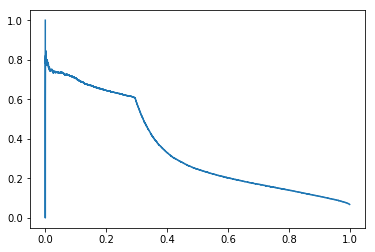

In [24]:
import matplotlib.pyplot as plt
plt.plot(r, p)

In [43]:
pitchers = df[['pitcher', 'pitcher_mlbname', 'pitcher_team']].drop_duplicates()
pitcher_embeddings = get_feature_embeddings(pitchers, 'pitcher', model)
x, y = zip(*pitcher_embeddings)

In [44]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform

output_notebook()

lookat = {
    'Noah Syndergaard': 'red',
    'Clayton Kershaw': 'green',
    'Aaron Nola': 'orange',
    'Craig Kimbrel': 'pink'
}

pitchers['sort_key'] = pitchers.pitcher_mlbname.isin(lookat)
pitchers.sort_values('sort_key', inplace=True)

source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            desc=pitchers.pitcher_mlbname
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap'],
           title="Mouse over the dots")

transformer = CategoricalColorMapper(
    factors=list(lookat.keys()),
    palette=list(lookat.values()),
    nan_color='blue')
p.circle('x', 'y', size=10, source=source, fill_color=transform('desc', transformer))
show(p)

Loading BokehJS ...

In [29]:
batters = df[['batter', 'batter_mlbname', 'batter_team', 'batter_pos']].drop_duplicates()
batter_embeddings = get_feature_embeddings(batters, 'batter', model)
x, y = zip(*batter_embeddings)

In [40]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
output_notebook()

lookat = {
    'Mike Trout': 'red',
    'Christian Yelich': 'green',
    'Bryce Harper': 'orange',
    'Mookie Betts': 'pink',
}

batters['sort_key'] = batters.batter_mlbname.isin(lookat)
batters.sort_values('sort_key', inplace=True)

source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            desc=batters.batter_mlbname
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom'],
           title="Mouse over the dots")

transformer = CategoricalColorMapper(
    factors=list(lookat.keys()),
    palette=list(lookat.values()),
    nan_color='blue')
p.circle('x', 'y', size=10, source=source, fill_color=transform('desc', transformer))
show(p)


Loading BokehJS ...

## Exploring numeric features

In [63]:
sample = df[
        ['pitcher_mlbname', 'batter_mlbname'] + categorical_features + numeric_features
        ].sample()
sample

,pitcher_mlbname,batter_mlbname,if_fielding_alignment,of_fielding_alignment,inning_topbot,pitch_name,zone,pitcher,batter,game_type,...,runner_on_third,away_score,bat_score,balls,strikes,outs_when_up,pitch_number,inning,total_pitch_number,at_bat_number
424743,Max Scherzer,Brock Holt,Standard,Standard,Top,4-Seam Fastball,9.0,453286.0,571788.0,R,...,0,3.0,3.0,1.0,1.0,2.0,3.0,3.0,60,23.0


In [64]:
with pd.option_context('display.max_columns', None):
    display(sample)

,pitcher_mlbname,batter_mlbname,if_fielding_alignment,of_fielding_alignment,inning_topbot,pitch_name,zone,pitcher,batter,game_type,stand,runner_on_first,runner_on_second,runner_on_third,away_score,bat_score,balls,strikes,outs_when_up,pitch_number,inning,total_pitch_number,at_bat_number
424743,Max Scherzer,Brock Holt,Standard,Standard,Top,4-Seam Fastball,9.0,453286.0,571788.0,R,L,1,0,0,3.0,3.0,1.0,1.0,2.0,3.0,3.0,60,23.0


In [ ]:
for 

# Recurrent model

In [222]:
encoder = Encoder()
encoder.fit(df)

In [223]:
numeric_features.remove('pitch_number')

ValueError: list.remove(x): x not in list

In [224]:
# sample_key = df[['game_pk', 'at_bat_number']].apply(lambda x: hash(tuple(x)) % 100, axis=1)
# df_sample = df[sample_key <= 10]
df_sample = df

In [225]:
df_sample.shape

(620560, 104)

In [226]:
from tqdm import tqdm_notebook as tqdm

df_sample.sort_values(['game_pk', 'at_bat_number', 'pitch_number'], inplace=True)

groups = df_sample.groupby([
    'game_pk', 'at_bat_number'
], as_index=False)
groups = list(groups)

X_train = []
y_train = []

def featurize_at_bat(group):
    (game_pk, at_bat_number), group_df = group
    x = encoder.transform(group_df[categorical_features])
    x['numeric_inputs'] = group_df[numeric_features].values
    y = group_df.is_on_base_event.max()
    return x, y, len(x['numeric_inputs'])

import multiprocessing as mp

pool = mp.Pool(2 * mp.cpu_count())
res = pool.imap_unordered(featurize_at_bat, tqdm(groups))
res = sorted(res, key=lambda x: x[-1])
X_train, y_train, batch_lens = zip(*res)


HBox(children=(IntProgress(value=0, max=158918), HTML(value='')))

Process ForkPoolWorker-106:
Process ForkPoolWorker-109:
Process ForkPoolWorker-111:
Process ForkPoolWorker-108:
Process ForkPoolWorker-110:
Process ForkPoolWorker-112:
Process ForkPoolWorker-113:
Process ForkPoolWorker-107:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/homebrew/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/local/homebrew/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/local/homebrew/Cellar/python3/3.6.2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call

KeyboardInterrupt
KeyboardInterrupt


In [227]:
len(X_train), len(y_train)

(158918, 158918)

## create the batches

In [228]:
import numpy as np

# assign each at-bat an ID so that each batch
# has roughly 32 pitches
batch_ids = np.cumsum(batch_lens) // 32
len(batch_ids), len(set(batch_ids))

(158918, 19393)

In [229]:
from itertools import groupby
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train), key=lambda x: next(i))

In [230]:
batch_id, batch = next(gb)
xs, ys = zip(*list(batch))
xs, ys

(({'batter_input': array([215]),
   'game_type_input': array([0]),
   'if_fielding_alignment_input': array([0]),
   'inning_topbot_input': array([1]),
   'numeric_inputs': array([[0., 0., 0., 0., 0., 1., 1., 1.]]),
   'of_fielding_alignment_input': array([0]),
   'pitch_name_input': array([0]),
   'pitcher_input': array([314]),
   'runner_on_first_input': array([0]),
   'runner_on_second_input': array([0]),
   'runner_on_third_input': array([0]),
   'stand_input': array([0]),
   'zone_input': array([8])},
  {'batter_input': array([234]),
   'game_type_input': array([0]),
   'if_fielding_alignment_input': array([0]),
   'inning_topbot_input': array([1]),
   'numeric_inputs': array([[ 3.,  0.,  0.,  0.,  1.,  2., 29., 11.]]),
   'of_fielding_alignment_input': array([0]),
   'pitch_name_input': array([0]),
   'pitcher_input': array([314]),
   'runner_on_first_input': array([0]),
   'runner_on_second_input': array([0]),
   'runner_on_third_input': array([0]),
   'stand_input': array([1]),


In [231]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

input_features = list(inputs.keys())
batch_id, batch = next(gb)
xs, ys = zip(*list(batch))

X_batch = {}

for f in input_features:
    X_batch[f] = pad_sequences([x[f] for x in xs])
y_batch = np.array(ys)

X_batch, y_batch

({'batter_input': array([[309],
         [412],
         [162],
         [309],
         [105],
         [227],
         [313],
         [145],
         [474],
         [385],
         [ 93],
         [378],
         [369],
         [381],
         [384],
         [ 24],
         [266],
         [ 24],
         [130],
         [ 27],
         [110],
         [102],
         [ 88],
         [ 37],
         [ 41],
         [ 25],
         [144],
         [108],
         [ 55],
         [ 41],
         [ 96],
         [121]], dtype=int32), 'game_type_input': array([[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
      

In [232]:
X_batch['numeric_inputs'].shape, X_batch['batter_input'].shape, y_batch.shape

((32, 1, 8), (32, 1), (32,))

In [233]:
def batch_generator(gb):
    for batch_id, batch in gb:
        xs, ys = zip(*list(batch))
        X_batch = {}
        for f in input_features:
            X_batch[f] = pad_sequences([x[f] for x in xs])
        yield X_batch, np.array(ys)
        

In [234]:
i = iter(batch_ids)
gb = groupby(zip(X_train, y_train), key=lambda x: next(i))
batches = list(batch_generator(gb))

In [235]:
len(batches)

19393

In [236]:
batches[0][0]['numeric_inputs'].shape, batches[0][1].shape

((31, 1, 8), (31,))

In [299]:
import keras
import keras.backend as K

categorical_dimmensions = {
    'batter': 2,
    'pitcher': 4,
}

numeric_input = keras.layers.Input((None, len(numeric_features),), name='numeric_inputs')
X_numeric_input = keras.layers.BatchNormalization()(numeric_input)

categorical_inputs = []
embeddings = []
for feature in categorical_features:
    input_ = keras.layers.Input((None,), name=f'{feature}_input')
    output_dim = categorical_dimmensions.get(feature, 1)
    embedding =  keras.layers.Embedding(input_dim=encoder.get_feature_dim(feature) + 1,
                                        output_dim=output_dim,
                                        name=f'{feature}_embedding')(input_)
    categorical_inputs.append(input_)
    embeddings.append(embedding)
X_embeddings = keras.layers.Concatenate(axis=-1)(embeddings)

X_in = keras.layers.Concatenate()([X_numeric_input, X_embeddings])
X = keras.layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1)(X_in)
X = keras.layers.BatchNormalization()(X)
X = keras.layers.Dense(1, activation='sigmoid')(X)

model = keras.models.Model(inputs=[numeric_input] + list(categorical_inputs), outputs=X)

In [300]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
if_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
of_fielding_alignment_input (In (None, None)         0                                            
__________________________________________________________________________________________________
inning_topbot_input (InputLayer (None, None)         0                                            
__________________________________________________________________________________________________
pitch_name_input (InputLayer)   (None, None)         0                                            
__________________________________________________________________________________________________
zone_input

In [301]:
model.compile(loss='binary_crossentropy', optimizer='adam')

In [303]:
# 0.4790
def g():
    while True:
        np.random.shuffle(batches)
        for X, y in batches:
            yield X, y
model.fit_generator(g(), steps_per_epoch=len(batches), epochs=25)

Epoch 1/25
19393/19393 [==============================] - 177s 9ms/step - loss: 0.5440
Epoch 2/25
19393/19393 [==============================] - 183s 9ms/step - loss: 0.5188
Epoch 3/25
19393/19393 [==============================] - 178s 9ms/step - loss: 0.5100
Epoch 4/25
19393/19393 [==============================] - 180s 9ms/step - loss: 0.5052
Epoch 5/25
19393/19393 [==============================] - 179s 9ms/step - loss: 0.5023
Epoch 6/25
19393/19393 [==============================] - 181s 9ms/step - loss: 0.5001
Epoch 7/25
19393/19393 [==============================] - 181s 9ms/step - loss: 0.4981
Epoch 8/25
19393/19393 [==============================] - 181s 9ms/step - loss: 0.4969
Epoch 9/25
19393/19393 [==============================] - 175s 9ms/step - loss: 0.4956
Epoch 10/25
19393/19393 [==============================] - 170s 9ms/step - loss: 0.4946
Epoch 11/25
19393/19393 [==============================] - 183s 9ms/step - loss: 0.4940
Epoch 12/25
 5980/19393 [========>.......

KeyboardInterrupt: 

## p/r curve just for kicks

In [304]:
preds = np.concatenate([model.predict(x) for x, _ in batches])
y_all = np.concatenate([y for _, y in batches])

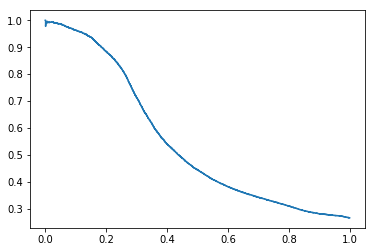

In [305]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
p, r, t = precision_recall_curve(y_all, preds)
plt.plot(r, p)

## look at batters

In [306]:
def get_feature_embeddings(X, feature, model):
    input_ = encoder.transform(X)[f'{feature}_input']
    return get_embeddings(input_, model, feature)

def get_embeddings(X, model, feature):
    input_ = model.get_layer(f'{feature}_input').get_output_at(-1)
    encoding = model.get_layer(f'{feature}_embedding').get_output_at(-1)
    return keras.models.Model(inputs=input_, outputs=encoding).predict(X)

In [307]:
batters = df[['batter', 'batter_mlbname', 'batter_team', 'batter_pos']].drop_duplicates()
batter_embeddings = get_feature_embeddings(batters, 'batter', model)
x, y = zip(*batter_embeddings.reshape((-1, 2)))

In [308]:
batter_embeddings.shape

(969, 1, 2)

In [309]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform
output_notebook()

lookat = {
    'Mike Trout': 'red',
    'Christian Yelich': 'green',
    'Bryce Harper': 'orange',
    'Mookie Betts': 'pink',
    'Rhys Hoskins': 'purple',
    'Jean Segura': 'grey'
}

batters['sort_key'] = batters.batter_mlbname.isin(lookat)
batters.sort_values('sort_key', inplace=True)

source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            desc=batters.batter_mlbname
#             desc=batters.apply(lambda x: str((x.batter_mlbname, x.batter_pos)), axis=1)
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap', 'wheel_zoom'],
           title="Mouse over the dots")

transformer = CategoricalColorMapper(
    factors=list(lookat.keys()),
    palette=list(lookat.values()),
    nan_color='blue')
p.circle('x', 'y', size=10, source=source, fill_color=transform('desc', transformer))
show(p)


Loading BokehJS ...

## look at pitchers

In [310]:
from sklearn.manifold import TSNE
pitchers = df[['pitcher', 'pitcher_mlbname']].drop_duplicates()
pitcher_embeddings = get_feature_embeddings(pitchers, 'pitcher', model)
x, y = zip(*TSNE(2).fit_transform(pitcher_embeddings.reshape((-1, 4))))

In [311]:
# https://gist.github.com/dela3499/e159b388258b5f1a7a3bac42fc0179fd

from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CategoricalColorMapper
from bokeh.io import output_notebook
from bokeh.transform import transform

output_notebook()

lookat = {
    'Noah Syndergaard': 'red',
    'Clayton Kershaw': 'green',
    'Aaron Nola': 'orange',
    'Craig Kimbrel': 'pink'
}

pitchers['sort_key'] = pitchers.pitcher_mlbname.isin(lookat)
pitchers.sort_values('sort_key', inplace=True)

source = ColumnDataSource(
        data=dict(
            x=x,
            y=y,
            desc=pitchers.pitcher_mlbname
        )
    )

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)"),
            ("desc", "@desc"),
        ]
    )

p = figure(plot_width=700, plot_height=700, tools=[hover, 'tap'],
           title="Mouse over the dots")

transformer = CategoricalColorMapper(
    factors=list(lookat.keys()),
    palette=list(lookat.values()),
    nan_color='blue')
p.circle('x', 'y', size=10, source=source, fill_color=transform('desc', transformer))
show(p)

Loading BokehJS ...